Instituto Politécnico Nacional

Centro de Investigación en Computación

Minería de datos I

Tarea 2.a. Programa de clasificación con el algoritmo del libro ID3, C4.5 o GINI.

Probar el algoritmo con dos conjuntos de datos (libro y otra fuente, puede ser un conjunto pequeño)

Presenta: Ana Maritza Bello

---

# Antecedentes

## Impureza y función de costo de un árbol de decisión

En el caso de los árboles de decisión, las dos funciones de costo principales son el índice de Gini y la entropía.

Cualquiera de las dos funciones de costo que se utilicen están basadas en la medida de la impureza. La impureza se refiere al hecho de que cuando hacemos un corte, qué tan probable es que la variable a clasificar sea clasificada incorrectamente.

La entropía es 0 si todas las muestras de un nodo pertenecen a la misma clase, y la entropía es máxima si tenemos una distribución uniforme. en otras palabras la entropía de un nodo es 0 ya que la probabilidad es 1 y el $log(1)=0$. La entropía alcanza su máximo valor cuando todas las clases en el nodo tienen la misma probabilidad.

1. Entropía de un grupo en el que todos los ejemplos pertenecen a la misma clase (no es bueno para entrenamiento):

$$ entropy = -1 log_2(1) =0 $$

2. Entropía de un grupo con 50% en cualquiera de las clases (buen conjunto para entrenamiento):

$$ entropy = -0.5 log_2(0.5) - 0.5 log_2(0.5) =1 $$

Similar a la entropía, el índice de Gini es máximo cuando las clases están perfectamente mezcladas, por ejemplo en una clase binaria:

$$ Gini = 1 - (p_1² + p_2²) = 1 - (0.5² + 0.5²) = 0.5 $$

### Ganancia de Información.

Claude Shannon inventó el concepto de entropía, que mide la impureza en el conjunto de entrada. En física y matemáticas, entropía se refiere a la aleatoriedad o impureza en un sistema. En teoría de la información, se refiere a la impureza en un grupo de ejemplos. La ganancia de información es el decrecimiento de la entropía. La ganancia de información calcura la diferencia entre la entropía antes de la partición y el promedio de la entropía despues de la partición del conjunto de datos basado en un valor de atributo dado. ID3 (Iterative Dichotomiser) usa ganancia de información.

Cuando tenemos un árbol demasiado profundo con muchas hojas, podemos tener sobreajuste del modelo. Para evitar esto, podamos el árbol ajustando una profundidad máxima.

Cuando usamos ganancia de información (IG), queremos determinar cual atributo en un conjunto de datos dado es más útil. En otras palabras, IG nos dice que tan importante es un atributo dado.

La ganancia de información puede definirse de la siguiente manera:

$$ IG(D_p) = I(D_p) - \frac{N_{left}}{N_p I(D_{left}} - \frac{N_{right}}{N_p I(D_{right}} $$

Donde $I$ puede ser la entropía, el índice de gini o el error de clasificación, $D_p$, $D_{left}$ y $D_{right}$ son el conjunto de datos del nodo ancestro, y el nodo hijo derecho e izquierdo.

### Relación de ganancia

C4.5, una mejora de ID3, utiliza una extensión de la ganancia de información conocida como índice de ganancia. El índice de ganancia maneja el problema del sesgo al normalizar la ganancia de información usando Split Info. La implementación Java del algoritmo C4.5 se conoce como J48 y está disponible en la herramienta de minería de datos WEKA.


# Algoritmo para generar árboles de desiciones usando el índice de gini como medida de impureza

En una primera aproximación, se utilizó el conjunto de datos del libro de minería de datos referente a una tienda de electrónicos. Para este conjunto de datos, la variable a predecir es si un cliente compra o no una computadora, basado en las características del historial de clientes como la edad, el ingreso, si es o no estudiante y su historial crediticio.

La idea detrás del algoritmo de decisión es la siguiente:

1. Seleccionar el mejor atritubo usando las medidas de selección de atributos para particionar los registros.
1. Hacer al atributo un nodo de decisión y partir el conjunto de datos en conjuntos más pequeños.
1. Construir el árbol repitiendo el proceso recursivamente para cada nodo hijo hasta que se cumpla una de las siguientes condiciones:
    1. Todas las tuplas pertenezcan al mismo atributo
    1. Ya no haya más atributos faltantes
    1. Ya no haya más registros

# Árbol de desición con variables discretas

In [153]:
%reset -f
import pandas as pd

allElectronicsCustomerDB = {
    'age': [
        'youth','youth','middle_aged','senior','senior','senior',
        'middle_aged','youth','youth','senior','youth','middle_aged',
        'middle_aged','senior'
        ],
    'income': [
        'high','high','high','medium','low','low','low','medium',
        'low','medium','medium','medium','high','medium'
        ],
    'student': [
        'no','no','no','no','yes','yes','yes','no',
        'yes','yes','yes','no','yes','no'
        ],
    'credit_rating': [
        'fair','excellent','fair','fair','fair',
        'excellent','excellent','fair','fair','fair',
        'excellent','excellent','fair','excellent'
        ],
    'buys_computer': [
        'no','no','yes','yes','yes','no','yes','no'
        ,'yes','yes','yes','yes','yes','no'
        ]
}

allElectronicsCustomerDB = pd.DataFrame(allElectronicsCustomerDB)

allElectronicsCustomerDB


,age,income,student,credit_rating,buys_computer
0,youth,high,no,fair,no
1,youth,high,no,excellent,no
2,middle_aged,high,no,fair,yes
3,senior,medium,no,fair,yes
4,senior,low,yes,fair,yes
5,senior,low,yes,excellent,no
6,middle_aged,low,yes,excellent,yes
7,youth,medium,no,fair,no
8,youth,low,yes,fair,yes
9,senior,medium,yes,fair,yes


In [154]:
# Calculate Gini Index for a feature

def gini_index(df, target, feature):
    gini = 0
    target_values = df[target].unique()
    #print("Target values {}: {}".format(target, target_values))
    feature_values = df[feature].unique()
    #print("Feature values {}: {} ".format(feature, feature_values))
    for feature_value in feature_values:
        p_val = 0
        for target_value in target_values:
            p = len(df[(df[feature] == feature_value) & (df[target] == target_value)]) / len(df[df[feature] == feature_value])
            #print("p({} = {}, {} = {}) = {}".format(feature, feature_value, target, target_value, p))
            p_val += p ** 2
        #print("p_val({} = {}) = {}".format(feature, feature_value, p_val))
        gini_feature = 1 - p_val
        #print("gini_feature({} = {}) = {}".format(feature, feature_value, gini))
        gini += (len(df[df[feature] == feature_value]) / len(df)) * gini_feature
    #print("gini = {} \n".format(gini))
    return gini

#gini_index(allElectronicsCustomerDB, 'buys_computer', 'student')

for feature in allElectronicsCustomerDB.columns[:-1]:
    print("Gini Index for {} is {}\n".format(feature, gini_index(allElectronicsCustomerDB, 'buys_computer', feature)))


Gini Index for age is 0.34285714285714286

Gini Index for income is 0.44047619047619047

Gini Index for student is 0.3673469387755103

Gini Index for credit_rating is 0.42857142857142855



In [155]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in allElectronicsCustomerDB.columns.values:
    if allElectronicsCustomerDB[col].dtypes == 'object':
        data = allElectronicsCustomerDB[col]
        le.fit(data.values)
        allElectronicsCustomerDB[col] = le.transform(allElectronicsCustomerDB[col])

allElectronicsCustomerDB

,age,income,student,credit_rating,buys_computer
0,2,0,0,1,0
1,2,0,0,0,0
2,0,0,0,1,1
3,1,2,0,1,1
4,1,1,1,1,1
5,1,1,1,0,0
6,0,1,1,0,1
7,2,2,0,1,0
8,2,1,1,1,1
9,1,2,1,1,1


In [156]:
feature_cols  = ['age', 'income', 'student', 'credit_rating']
target_class = ['buys_computer']

X = allElectronicsCustomerDB[feature_cols]
y = allElectronicsCustomerDB[target_class]

dt_model = DecisionTreeClassifier(criterion='gini')
dt_model.fit(X, y)

DecisionTreeClassifier()

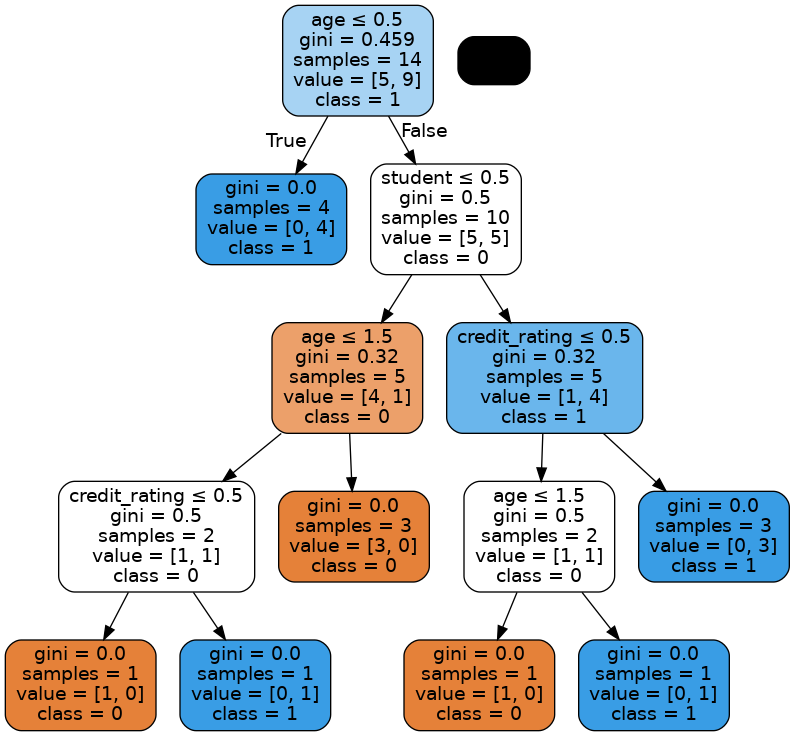

In [157]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('buys_computer.png')
Image(graph.create_png())

# Cálculo del índice de Gini en conjunto de datos con valores de atributos continuos.

El conjunto de datos utilizado corresponde a registros de pacientes con diabetes. El objetivo es predecir si una paciente tiene o no diabetes basado en ciertas medidas tomadas de los pacientes.

En el caso de los atributos con valores continuos, la estrategia es seleccionar cada par de valores adyacentes como un posible punto de partición, y el punto con el índice de gini más pequeño se escoge como el _splitting point_.

Para hacer esto debemos de seguir los siguientes pasos:

1. Ordenar los valores de la variable en orden ascendente.
1. Escoger como _splitting points_ los valores medios entre valores adyacentes como se muestra en la siguiente figura.

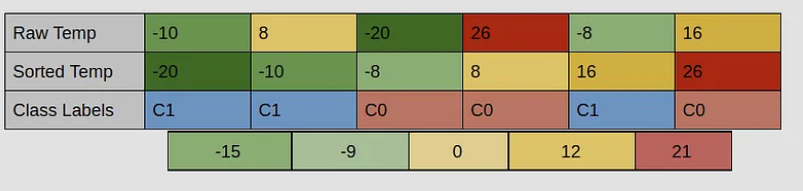

El número de candidatos después de tomar el punto medio del arreglo ordenado puede ser computacionalmente costoso. Una versión optimizada implica la selección de candidatos de puntos medios con diferentes etiquetas de clase.

Algunos métodos más sofisticados incluyen el uso de algoritmos de aprendizaje no supervisado para definir las categorías óptimas.


In [158]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']

# load dataset
diabetes_df = pd.read_csv("../data/diabetes.csv", header=None, names=col_names, skiprows=1)
diabetes_df.head(5)

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [159]:
feature_cols = ['pregnant','glucose','bp', 'insulin', 'bmi', 'age', 'pedigree']
X = diabetes_df[feature_cols]
y = diabetes_df.label

In [160]:
# Create Decision Tree classifer object
model_dt = DecisionTreeClassifier(criterion='gini')

# Train Decision Tree Classifer
model_dt = model_dt.fit(X,y)

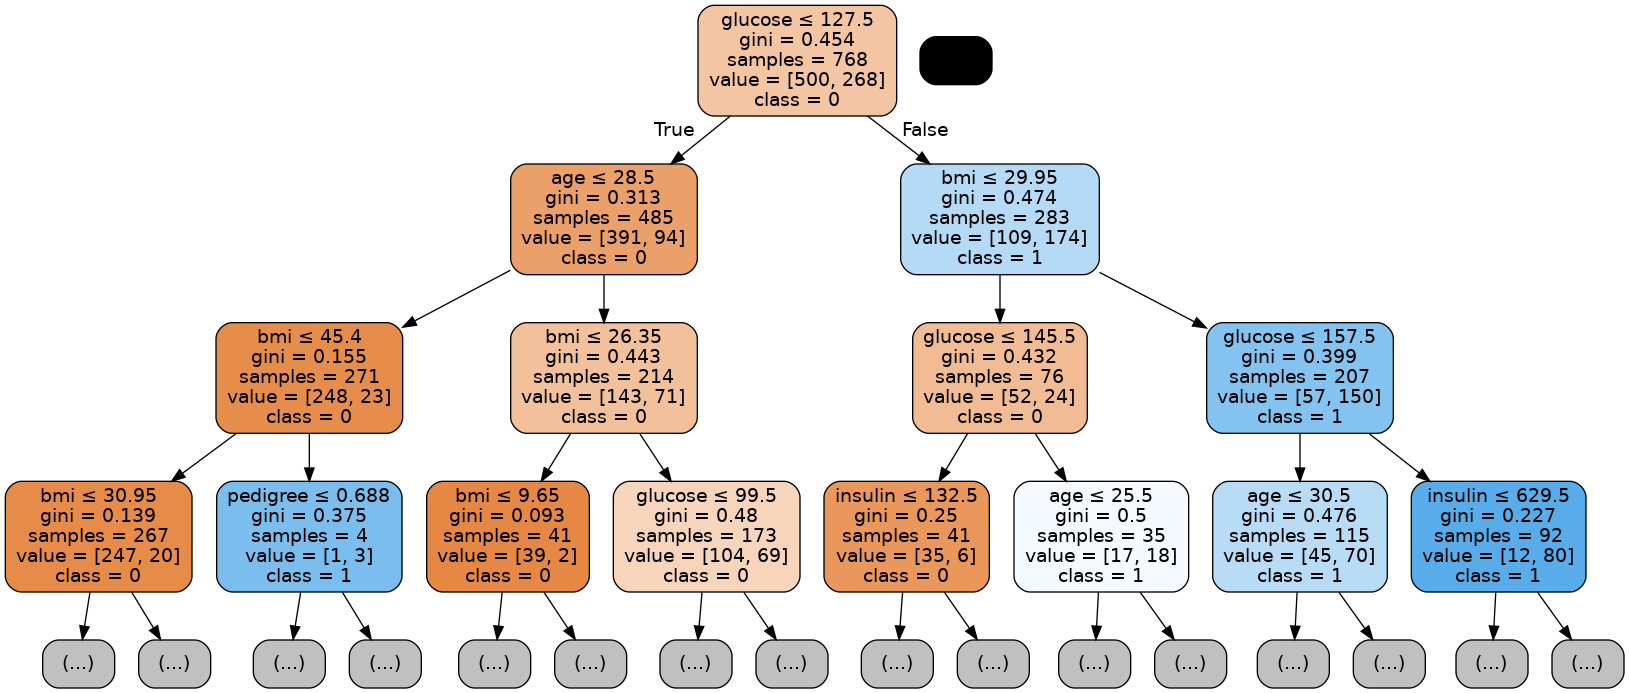

In [165]:
# Visualize the tree

dot_data = StringIO()
export_graphviz(model_dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'], max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('diabetes.pdf')
Image(graph.create_png())


# References

- [SCIKIT-LEARN : DECISION TREE LEARNING I - ENTROPY, GINI, AND INFORMATION GAIN](https://www.bogotobogo.com/python/scikit-learn/scikt_machine_learning_Decision_Tree_Learning_Informatioin_Gain_IG_Impurity_Entropy_Gini_Classification_Error.php)

- [Decision Tree Classification in Python Tutorial](https://www.datacamp.com/tutorial/decision-tree-classification-python)

- [How to program a decision tree in Python from 0](https://anderfernandez.com/en/blog/code-decision-tree-python-from-scratch/)

- [Handling Continuous features in Decision Trees](https://medium.com/geekculture/handling-continuous-attributes-in-decision-trees-bbc044986621)